In [2]:
# load and modify the data 
# for all data in gyro 

import matplotlib.pyplot as plt
import ast
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

frames = []
threshold = 80
file_index = "0007"
index_avg = 18
bs = 10


file_name = f"gyro_data/gyro_data_{file_index}.txt"


plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
fs = 12

def modify_data(data, expected_length=19):

    # convert to integer
    serial_data = ast.literal_eval(data)

    print(serial_data)

    # Define a regular expression pattern to match valid strings
    valid_pattern = re.compile(r'^-?\d+$')  

    # Filter out entries with invalid strings or empty strings
    filtered_data = [row for row in serial_data if all(valid_pattern.match(value.strip()) for value in row) and all(value.strip() for value in row)]

    # Check each entry for the correct number of values
    incorrect_entries = []
    for index, entry in enumerate(filtered_data):
        if len(entry) != expected_length:
            print(f"Entry at index {index} has {len(entry)} values instead of {expected_length}.")
            incorrect_entries.append(index)
    
    # Remove entries with incorrect number of values
    for index in sorted(incorrect_entries, reverse=True):
        del filtered_data[index]
    
    stripped_data = [[int(value.strip()) for value in row] for row in filtered_data]  

    # transpose the data 
    transposed_data = list(map(list, zip(*stripped_data)))   

    return transposed_data

def determine_laser(mod_data):
    laser_state = []

    # such that all minima are found
    for i in range(2):
        laser_state.append(1)

    for i in range(len(mod_data[index_avg])-4):
        temp = mod_data[index_avg][i:i+bs]

        # all values need to be inbetween |threshold|
        if all(-threshold < t < threshold for t in temp):
            laser_state.append(1)
        else:
            laser_state.append(0)

    for i in range(2):
        laser_state.append(1)

    return laser_state

def find_laser_on_off(laser_state,index):

    start_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 1 and laser_state[i-1] == 0]
    end_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 0 and laser_state[i-1] == 1]

    start_on = start_on[0:len(start_on)-1]
    end_on = end_on[1:len(end_on)]
    return start_on, end_on

with open(file_name, "r") as file:
    serial_data = file.read()

mod_data = modify_data(serial_data)

index = [i for i in range(len(mod_data[18]))]
print(index)
# determine laser state
laser_state = determine_laser(mod_data)

# calculate minima of laser 

start_on, end_on = find_laser_on_off(laser_state, index)
# calculate minima of laser 
minima, _ = find_peaks(-np.array(laser_state))

print(laser_state)
print(start_on)
print(end_on)

# [accX, ma_accX, dev_accX, accY, ... , dev_accZ, gyrX, ma_gyrX, dev_gyrX, gyrY, ... , dev_gyrZ, acc_vec, laser_state]
gyro_data = {'index': [i for i in range(len(mod_data[0]))],
            'accX':     mod_data[0],
            'avg_accX': mod_data[1],
            'dev_accX': mod_data[2],
            'accY':     mod_data[3],
            'avg_accY': mod_data[4],
            'dev_accY': mod_data[5],
            'accZ':     mod_data[6],
            'avg_accZ': mod_data[7],
            'dev_accZ': mod_data[8],
            'gyrX':     mod_data[9],
            'avg_gyrX': mod_data[10],
            'dev_gyrX': mod_data[11], 
            'gyrY':     mod_data[12],
            'avg_gyrY': mod_data[13],
            'dev_gyrY': mod_data[14],
            'gyrZ':     mod_data[15],
            'avg_gyrZ': mod_data[16],
            'dev_gyrZ': mod_data[17], 
            'acc_vec':  mod_data[index_avg],
            'laser':    laser_state}

pd_gyro = pd.DataFrame(data = gyro_data)               

frames.append([file_index, pd_gyro, minima, start_on, end_on])


[['1', ' -1', ' 1'], ['-15140', ' -15160', ' 22', ' -460', ' -484', ' 28', ' -2076', ' -2230', ' 25', ' -261', ' I2232', ' -2259', ' 95', ' -207', ' -234', ' -15', ' 289', ' 252', ' -4', ' -409', ' -411', ' -1', ' 1'], ['-15140', ' -15160', ' 22', ' -460', ' -484', ' 28', ' -2076', ' -2230', ' 25', ' -261', ' I-15220', ' -3044', ' 3044', ' -440', ' -88', ' 88', ' -2236', ' -447', ' 447', ' -250', ' -50', ' 50', ' 242', ' 48', ' -48', ' -419', ' -83', ' 83', ' 3077'], ['-15184', ' -6080', ' 6080', ' -400', ' -168', ' 168', ' -2216', ' -890', ' 890', ' -227', ' -95', ' 95', ' 288', ' 106', ' -106', ' -406', ' -165', ' 165', ' 3070'], ['-15016', ' -9084', ' 9084', ' -452', ' -258', ' 258', ' -2040', ' -1298', ' 1298', ' -222', ' -139', ' 139', ' 264', ' 158', ' -158', ' -408', ' -246', ' 246', ' 3032'], ['-15100', ' -12104', ' 12104', ' -460', ' -350', ' 350', ' -2128', ' -1724', ' 1724', ' -245', ' -188', ' 188', ' 213', ' 201', ' -201', ' -412', ' -329', ' 329', ' 3052'], ['-15200', ' -

In [3]:
# load and modify the data 
# from merge_data on (0071 oder so)

import matplotlib.pyplot as plt
import ast
import re
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.patches as patches

frames = []
threshold = 110
file_index = "0071"
args = ['0071','0072','0073']
index_avg = 18
bs = 100
start = 100




plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
fs = 12

def modify_data(data, expected_length=1):

    # convert to integer
    serial_data = ast.literal_eval(data)

    new_serial_data  = []

    for i in range(len(serial_data)):
        new_serial_data.append(serial_data[i][0])

    return new_serial_data

def determine_laser(mod_data):
    laser_state = []

    # such that all minima are found
    for i in range(2):
        laser_state.append(1)

    for i in range(len(mod_data)-4):
        temp = mod_data[i:i+bs]

        # all values need to be inbetween |threshold|
        if all(-threshold < t < threshold for t in temp):
            laser_state.append(1)
        else:
            laser_state.append(0)

    for i in range(2):
        laser_state.append(1)

    return laser_state

def find_laser_on_off(laser_state,index):

    start_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 1 and laser_state[i-1] == 0]
    end_on = [index[i] for i in range(1, len(laser_state)) if laser_state[i] == 0 and laser_state[i-1] == 1]

    start_on = start_on[0:len(start_on)]
    end_on = end_on[0:len(end_on)]
    return start_on, end_on

for arg in range(len(args)):
    file_index = args[arg]
    file_name = f"../merge/merge_data/merge_data_{file_index}.txt"

    with open(file_name, "r") as file:
        serial_data = file.read()

    mod_data = modify_data(serial_data)
    end = len(mod_data)

    index = [i for i in range(len(mod_data))]
    # determine laser state
    laser_state = determine_laser(mod_data)

    # calculate minima of laser 
    minima, _ = find_peaks(-np.array(laser_state[start:end]))

    start_on, end_on = find_laser_on_off(laser_state, index)
    print(laser_state)
    print(start_on)
    print(end_on)

    # [accX, ma_accX, dev_accX, accY, ... , dev_accZ, gyrX, ma_gyrX, dev_gyrX, gyrY, ... , dev_gyrZ, acc_vec, laser_state]
    gyro_data = {'index': index,
                'acc_vec':  mod_data,
                'laser':    laser_state}

    pd_gyro = pd.DataFrame(data = gyro_data)               

    frames.append([file_index, pd_gyro, minima, start_on, end_on])


[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

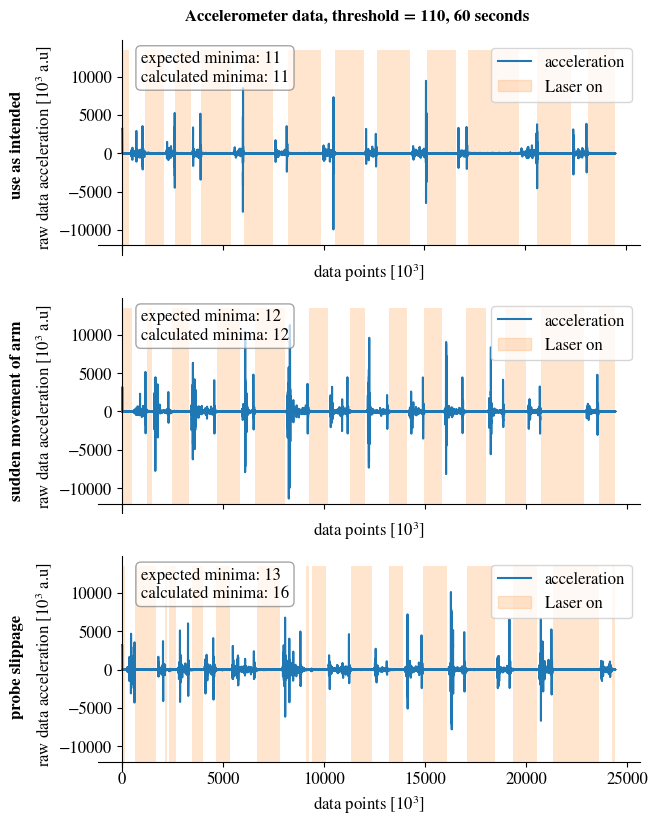

In [26]:
# plot the data 

fig, axs = plt.subplots(3,1,figsize=(7,9.5))

def make_text():
    fig.text(0.25,0.90,f"Accelerometer data, threshold = {threshold}, 60 seconds", fontsize=fs, weight='bold')

    axs[0].set_xticklabels([])
    axs[1].set_xticklabels([])

    fig.text(0.01, 0.77, 'use as intended', va='center', ha='center', rotation='vertical', fontsize=fs, weight='bold')
    fig.text(0.01, 0.49, 'sudden movement of arm', va='center', ha='center', rotation='vertical', fontsize=fs, weight='bold')
    fig.text(0.01, 0.22, 'probe slippage', va='center', ha='center', rotation='vertical', fontsize=fs, weight='bold')
    

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        expected_min = 11
    if i == 1:
        expected_min = 12
    if i == 2:
        expected_min = 13

    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position(('data', -12000)
                                     ) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor='grey')    
    textstr = '\n'.join((
        r'expected minima: %.0d' % (expected_min,),
        r'calculated minima: %.2d' % (len(frames[i][2]), )))    
    ax.text(0.08, 0.95, textstr, transform=ax.transAxes, fontsize=fs,
        verticalalignment='top', bbox=props)
    
    ax.plot(list(frames[i][1].index), list(frames[i][1].acc_vec), label = 'acceleration')
    ax.fill_between([], [], color = 'C1', alpha = 0.2,label = 'Laser on')

    #ax.ylim([-2500,2500])
    ax.set(xlabel = r'data points [$10^{3}$]', ylabel = r'raw data acceleration [$10^{3}$ a.u]')

    ax.legend(loc="upper right")
    start_on = frames[i][3]
    end_on = frames[i][4]
    for j in range(len(frames[i][3])-1):     # frames[0][3] = start_on           
        ax.add_patch(patches.Rectangle((start_on[j], -12000), end_on[j+1]-start_on[j], 25500, linewidth=0,  color='C1', alpha=0.2)) 
    ax.add_patch(patches.Rectangle((start_on[len(start_on)-1], -12000), len(list(frames[i][1].acc_vec))-start_on[len(start_on)-1], 25500, linewidth=0,  color='C1', alpha=0.2))

    sns.despine()

make_text()
#plt.tight_layout()
name_file = f"Gyro_3x1_threshold_{threshold}"
# plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.pdf")
# plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.png")
# plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.svg")




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


24492


C:\Users\Anna\AppData\Local\Temp\ipykernel_17292\333937569.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


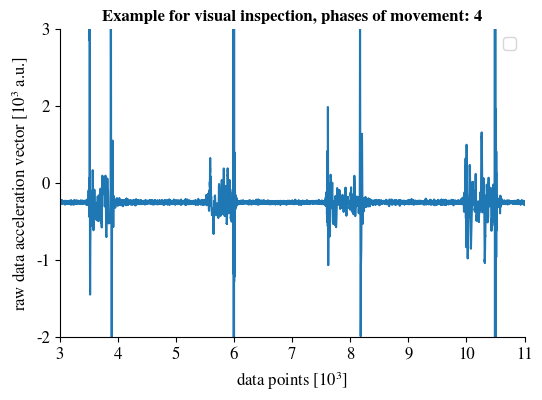

In [27]:
# example plot for minima bestimmung
fig, ax = plt.subplots(figsize=(6,4))

def raw_to_voltage(raw):
    return raw * (5.0 / 1023)

def plots():  
    print(len(list(frames[0][1].index)))  
    plt.plot(list(frames[0][1].index), list(frames[0][1].acc_vec))
    # plt.plot(list(frames[0][1].index), list(frames[0][1].laser), label = 'expected minima')

    ax.set_title(f"Example for visual inspection, phases of movement: 4", fontsize=fs, weight='bold')
    ax.set(xlabel = r'data points $[10^3]$', ylabel = r'raw data acceleration vector [$10^3$ a.u.]')

    ax.legend(loc="upper right")
    sns.despine()

    #ax.set_ylim(-200,200)
    plt.xlim(3000,11000)

    ax.set_ylim([-2400, 3100])
    raw_ticks = np.linspace(-2400, 3100, 5)  # 11 ticks from 0 to 1023
    voltage_ticks = raw_to_voltage(raw_ticks)
    ax.set_yticks(raw_ticks)
    ax.set_yticklabels([f'{tick:.1f}' for tick in voltage_ticks])

    xlabels = ['{:,.0f}'.format(y) for y in ax.get_xticks()/1000]
    ax.set_xticklabels(xlabels)    
    ylabels = ['{:,.0f}'.format(y) for y in ax.get_yticks()/1000]
    ax.set_yticklabels(ylabels)
   # ax.set(xlabel='data points $[10^3]$', ylabel='[$10^3$ a.u.]' )


plots()

name_file = f"gyro_example_visual_inspection"
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.pdf")
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.png")
plt.savefig(f"../../../LaTex/Master Thesis/figures/{name_file}.svg")

